In [108]:
import numpy as np
from dualtime.src.mclachlan import VarQITE
from gibbs.utils import create_hamiltonian_lattice,printarray,expected_state,state_from_ansatz, simple_purify_hamiltonian,expected_state, create_heisenberg
from gibbs.preparation.varqite import brute_force_optimization, pauli_rotations_ansatz
from gibbs.preparation.free_energy import brute_cmaes
from gibbs.learning.klocal_pauli_basis import KLocalPauliBasis
from qiskit.circuit import ClassicalRegister
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import SparsePauliOp,Statevector, state_fidelity, DensityMatrix
from gibbs.learning.hamiltonian_learning import HamiltonianLearning
from scipy.linalg import expm, logm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this notebook we are going to summarize a method of Hamiltonian Learning for steady states of our Hamiltonian. A steady state of a hamiltonian is any state s.t $[H,\rho]$ = 0. For example the thermal state $\rho_{Gibbs} = \frac{1}{\mathcal{Z}}e^{-\beta H}$ satisfies this property.
Let's begin by creating such a state.

In [109]:
H =create_hamiltonian_lattice(4,1/4,-1)
print(H)
gibbs_state = expm(-H.to_matrix()); gibbs_state /= np.trace(gibbs_state)

SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[ 0.25+0.j,  0.25+0.j,  0.25+0.j, -1.  +0.j, -1.  +0.j, -1.  +0.j,
 -1.  +0.j])


Now we have got a fairly large state, for which performing full state tomography would be rather expensive. However, we notice that the hamiltonian that generated is k-local. That means that we wouldn't really need to perform full state tomography on the state in order to `know` it if we could just learn the few terms in the Hamiltonian instead.
In order to do so, we want to use a Hamiltonian learning thechnique based on commutation relationships between our state and the Hamiltonian we are trying to learn.
Note that we can express k-local Hamiltonians as a vector in the k-local Pauli basis. What this mean is that we arrange the k-Pauli operators in some arbitrary order, and then we assign the coefficients of each term to each of the entries of a vector.

In [110]:
local2_basis = KLocalPauliBasis(2,10,periodic = False)
print(local2_basis.paulis_list)

['XIIIIIIIII', 'IXIIIIIIII', 'IIXIIIIIII', 'IIIXIIIIII', 'IIIIXIIIII', 'IIIIIXIIII', 'IIIIIIXIII', 'IIIIIIIXII', 'IIIIIIIIXI', 'IIIIIIIIIX', 'YIIIIIIIII', 'IYIIIIIIII', 'IIYIIIIIII', 'IIIYIIIIII', 'IIIIYIIIII', 'IIIIIYIIII', 'IIIIIIYIII', 'IIIIIIIYII', 'IIIIIIIIYI', 'IIIIIIIIIY', 'ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ', 'XXIIIIIIII', 'IXXIIIIIII', 'IIXXIIIIII', 'IIIXXIIIII', 'IIIIXXIIII', 'IIIIIXXIII', 'IIIIIIXXII', 'IIIIIIIXXI', 'IIIIIIIIXX', 'XYIIIIIIII', 'IXYIIIIIII', 'IIXYIIIIII', 'IIIXYIIIII', 'IIIIXYIIII', 'IIIIIXYIII', 'IIIIIIXYII', 'IIIIIIIXYI', 'IIIIIIIIXY', 'XZIIIIIIII', 'IXZIIIIIII', 'IIXZIIIIII', 'IIIXZIIIII', 'IIIIXZIIII', 'IIIIIXZIII', 'IIIIIIXZII', 'IIIIIIIXZI', 'IIIIIIIIXZ', 'YXIIIIIIII', 'IYXIIIIIII', 'IIYXIIIIII', 'IIIYXIIIII', 'IIIIYXIIII', 'IIIIIYXIII', 'IIIIIIYXII', 'IIIIIIIYXI', 'IIIIIIIIYX', 'YYIIIIIIII', 'IYYIIIIIII', 'IIYYIIIIII', 'IIIYYIIIII', 'IIIIYYIIII', 'IIII

As we can see in the example above, this are all the 2-k local terms that exist in 10 qubits (Assuming that we don't have periodic boundary conditions).

In [111]:
def number_of_elements(k,n): # (n-k+1) * (3/4)**2 * 4**k
    if k ==1:
        return 3*n
    
    #The inner block of operators will be formed by {I,X,Y,Z}^{k-2}
    inner_block = 4**(k-2)
    #The blocks of this border need to be formed by {X,Y,Z}^2. If we have an identity in the border it would be a k-1 local term.
    outer_block = 3**2
    #Finally this block of operators is free to move around the lattice.
    shifting = n-k+1 # This would just be n for periodic boundary conditions
    return inner_block*outer_block*shifting

total_number_elements = lambda k,n : sum(number_of_elements(i,n) for i in range(1,k+1))
assert total_number_elements(4,10) == len(KLocalPauliBasis(4,10).paulis_list) #Just checking that the number of elements is correct

For $k \ll n$, we imidiately see that the number of terms will scale like $\mathcal{O}(n4^k)$.

For example for k=4 and n=30 we have 5.25e+03 k-local terms vs 1.15e+18 terms we would need for full state tomography


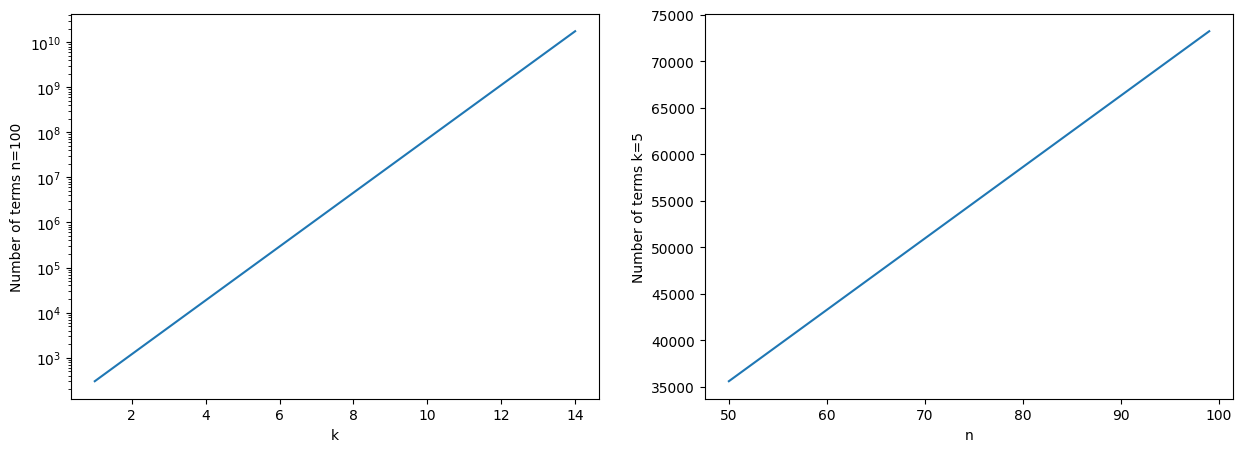

In [112]:
nn = 100
kk = 5
range_k = np.arange(1,15)
range_n = np.arange(50,100)
number_terms_k = [total_number_elements(k,nn) for k in range_k]
number_terms_n = [total_number_elements(kk,n) for n in range_n]

#Create a plot of the number of terms in function of k and an other plot in function of n
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(range_k,number_terms_k)
ax[0].set_yscale("log")
ax[0].set_xlabel("k")
ax[0].set_ylabel(f"Number of terms n={nn}")
ax[1].plot(range_n,number_terms_n)
ax[1].set_xlabel("n")
ax[1].set_ylabel(f"Number of terms k={kk}")

print(f"For example for k=4 and n=30 we have {total_number_elements(4,30):.2e} k-local terms vs {4**30:.2e} terms we would need for full state tomography")

Therefore, if possible we would like to just learn the k-local terms of our Hamiltonian. Note the following property:
$$
\langle i[A_q,H] \rangle _{\rho } =Tr[i [A_q,S_m]\rho] = Tr[iA_q[H,\rho]]=0
$$

This means that for any operator $A_q$ we will have that the expectation value of $[A_q,H]$ with respect to our thermal state will be 0. By imposing enough constraints $\{A_q\}$, we will create a system of equations that will allow us to find the original H. More formally, if we write $H = \sum c_m S_m$ with $\{S_m\}$ being the k-local Pauli basis, we have that:

$$
K \cdot \vec{c} = \sum K_{q,m} c_m = \sum c_m \langle i[A_q,S_m] \rangle _{\rho } = \langle i[A_q,H] \rangle _{\rho } = 0
$$
And therefore $H = \vec{S} \cdot \vec{c}$ will be in the kernel of $K_{q,m} = [A_q,S_m]$.

All we need to do now, is to define the set of constraints $\{A_q\}$. Technically we can choose any set of operators as long as $|A|>|S|$ (which is required so that we can find solutions to $K\vec{c}$ ). However, if we want to be practical we will choose A to be formed by Pauli operators that are easy to measure. The choice of the most optimal set of Pauli operators is an open question, and might depend on the locality of our system. For example, if the correlation lenght of our system is small, we will probably want to choose k-small-local Pauli operators so that we can perform several measurements at the same time.

Note as well that although $|K| = |A| \cdot |S| $, in practice we will not have to measure each commutator individually. Here are some examples:

* $\langle[XXI,IYY]\rangle _{\rho } = \langle [IXY,XYI]\rangle _{\rho } = 2\langle XZY \rangle _{\rho } $, we can get several entries just by measuring one operator.
* $[XXI,IXY] = 0 \implies \langle[XXI,IXY]\rangle _{\rho }=0 $, for some cases we know beforehand that the commutator is going to be 0.

This last example, is the reason why we might consider the set of k+1-local Pauli operators a good candidate for our set of constraints. This way the set of constraint operators is large enough, and at the same time most of the entries in K will be 0.

In [113]:
K_size = total_number_elements(2,30)*total_number_elements(3,30)
print(f"K will have {K_size:.2e} entries but we will only need to measure between {total_number_elements(3,30):.2e} and {total_number_elements(4,30):.2e} operators")

K will have 4.77e+05 entries but we will only need to measure between 1.36e+03 and 5.25e+03 operators


As we see, just by measuring $\approx 10^3$ pauli operators we will be able to construct the matrix K that has $\approx 10^5 $ terms. On top of that, by taking k+1-local Pauli operators we get a considerably larger number of constraints (while only increasing by a factor of 4 the ammount of measurements we need to perform), which will help to increase the precision of our scheme, specially in the presence of noise.


!["asdf"](numberconstraints.png) 

Now, let's do a specific example. We will try to recover our hamiltonian from our thermal state. We will start by creating an instance of our Hamiltonian Learning class and sampling the necessary Paulis.

In [114]:
hl = HamiltonianLearning(DensityMatrix(gibbs_state),2,3)
#We start by sampling the paulis. The sampling will consist in measuring the expectation value of all the paulis in the sampling basis.
print(f"The sampling basis has {len(hl.sampling_basis.paulis_list)} elements")
hl.sample_paulis()

The sampling basis has 255 elements


Now we will create the K matrix. It will be a sparse Matrix with very few non-zero elements.

In [115]:
hl.create_constraint_matrix()
display(hl.constraint_matrix)

<111x39 sparse matrix of type '<class 'numpy.complex128'>'
	with 584 stored elements in Compressed Sparse Row format>

Finally we will have to find the kernel of K. In order to do so we are going to find the singular values with associated singular values. The kernel will correspond to those vectors with singular value 0.

In this case since we didn't simulate any noise, we would expect to have a perfect reconstruction. This means that we only have one candidate with a 0 singular value.

In [116]:
from scipy.sparse.linalg import eigsh
KTK = hl.constraint_matrix.T.conj() @ hl.constraint_matrix
display(KTK)
singular_values, singular_vectors = eigsh(KTK,k=4,which="SM")
print("In this example we can clearly see that there is a gap between the first and second singular values:")
print(singular_values)

#Finally we can reconstruct the original hamiltonian using the first singular vector.
reconstructed_hamiltonian = hl.learning_basis.vector_to_pauli_op(singular_vectors[:,0])
print("And this is the reconstructed hamiltonian:")
print(reconstructed_hamiltonian)

<39x39 sparse matrix of type '<class 'numpy.complex128'>'
	with 399 stored elements in Compressed Sparse Column format>

In this example we can clearly see that there is a gap between the first and second singular values:
[-2.50392809e-16  1.17261123e-03  2.21836864e-03  2.51355722e-03]
And this is the reconstructed hamiltonian:
SparsePauliOp(['XIII', 'IXII', 'IIXI', 'IIIX', 'ZZII', 'IZZI', 'IIZZ'],
              coeffs=[-0.21390772+0.43937394j, -0.21390772+0.43937394j, -0.21390772+0.43937394j,
 -0.21390772+0.43937394j,  0.05347693-0.10984348j,  0.05347693-0.10984348j,
  0.05347693-0.10984348j])


Note that we have reconstructed the hamiltonian but only up to a factor. The reason for this, is that while $\rho$ is a steady state of $H$, it also is a steady state of $\alpha H$. Therefore, there is not much that we can do in order to reconstruct our original hamiltonian, however, we know that it lies in a 1 dimensional subspace.

For the usecase of trying to prepare faulty Gibbs States and then doing tomography on our final state to see how far we are from the intended state, we can use our analytical knowledge of the original hamiltonian so in order to find $\alpha$ s.t. $H_{faulty} \approx \alpha H_{learned}$.
We will do the following assumptions:
* $ H_{faulty} = H_{original} +  \Delta H $.
* We define $\vec{c}_{name}$ is the vector s.t. $H_{name} = \vec{S} \cdot \vec{c}_{name}$, with $\vec{S}$ the k-local basis.
* We can decompose $\vec{c}_{\Delta} = \epsilon \cdot \vec{c}_{original} + \vec{c}_{T}$ and $\epsilon \ll ||\vec{c}_{T}||$.

The reason we can do this last assumption would be that if the error is ditributed at random, given a high dimensional vector, the component of $\vec{c}_{\Delta}$ non-orthogonal to $\vec{c}_{original}$ should be very small.

Now, let's try to repeat the learning process but starting with a small error.

In [117]:
H_original =create_hamiltonian_lattice(4,1/4,-1)
epsilon = 0.5/40
H_faulty = (H_original*(1+epsilon) + SparsePauliOp.from_list([("IZII",0.5)])).simplify()
faulty_state = expm(-H_faulty.to_matrix()); faulty_state /= np.trace(faulty_state)
hl_faulty = HamiltonianLearning(DensityMatrix(faulty_state),2,3)
c_original = hl_faulty.learning_basis.pauli_to_vector(H_original)
c_faulty = hl_faulty.learning_basis.pauli_to_vector(H_faulty)

hl_faulty.sample_paulis()
hl_faulty.create_constraint_matrix()
hl_faulty.reconstruct_hamiltonian()
c_learned = hl_faulty.singular_decomposition[0][1]

print("The vector of the original hamiltonian is:")
printarray(c_original)
print("The vector of the learned hamiltonian is:")
printarray(c_learned)

The vector of the original hamiltonian is:
[-1.   -1.   -1.   -1.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.25  0.25  0.25]
The vector of the learned hamiltonian is:
[ 0.475  0.475  0.475  0.475  0.     0.     0.     0.     0.    -0.235
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    -0.119 -0.119 -0.119]


Now that we have learned the faulty state, we notice that apart from the scaling, we have an extra term in the vector. We would like to isolate that term.
We can try to plot both our original hamiltonian and the learned subspace.
We will use the following axis:
* $\hat{c}_{original} = \frac{1}{||\vec{c}_{original}||} \vec{c}_{original}$

* $\hat{c}_{T} = \frac{1}{||\vec{c}_{T}||} \vec{c}_{T}$
* With $\vec{c}_T = \hat{c}_{learned} - \langle \hat{c}_{learned},\vec{c}_{original} \rangle \cdot \hat{c}_{original}$

Note that $\vec{c}_{\Delta} = \epsilon \hat{c}_{original} + ||\vec{c}_T|| \hat{c}_{T}$.

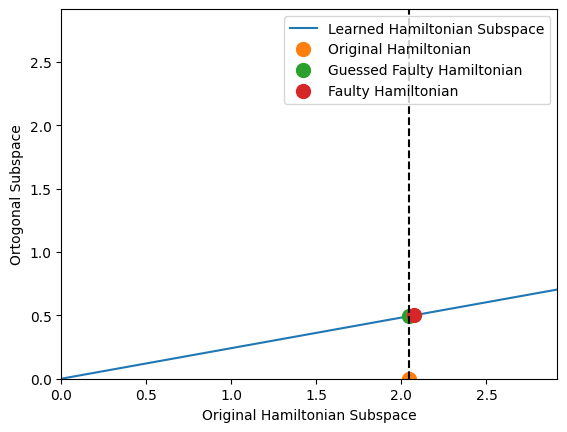

We get a relative error of 0.01234567901258263


In [124]:
c_hat_original = c_original.copy(); c_hat_original /= np.linalg.norm(c_hat_original)
c_hat_T = c_learned - np.dot(c_hat_original,c_learned) * c_hat_original; c_hat_T /= np.linalg.norm(c_hat_T)

c_guessed_faulty = c_learned * np.linalg.norm(c_original) / np.abs(np.dot(c_hat_original,c_learned))


xlim=3
plt.plot([0,xlim*np.abs(np.dot(c_hat_original,c_learned))],[0,xlim*np.dot(c_hat_T,c_learned)], label="Learned Hamiltonian Subspace")
plt.plot([np.linalg.norm(c_original)],[0], marker="o", markersize=10, linestyle="None", label="Original Hamiltonian")
plt.plot([np.abs(np.dot(c_hat_original,c_guessed_faulty))],[np.dot(c_hat_T,c_guessed_faulty)], marker="o", markersize=10, linestyle="None", label="Guessed Faulty Hamiltonian")
plt.plot([np.dot(c_hat_original,c_faulty)],[np.abs(np.dot(c_hat_T,c_faulty))], marker="o", markersize=10, linestyle="None", label="Faulty Hamiltonian")
plt.vlines(x=np.linalg.norm(c_original), ymin=0, ymax=xlim, linestyle="--", color="black")
plt.xlim(0, xlim*np.abs(np.dot(c_hat_original,c_learned)))
plt.ylim(0, xlim*np.abs(np.dot(c_hat_original,c_learned)))
plt.xlabel("Original Hamiltonian Subspace")
plt.ylabel("Ortogonal Subspace")
plt.legend()
plt.show()

print("We get a relative error of",np.linalg.norm(c_guessed_faulty+c_faulty)/np.linalg.norm(c_faulty))

Note that here we have exagerated the error term $\epsilon$, but we can expect this value to be much smaller. Note as well, how for $\epsilon \ll 1$ we have that the guessed faulty hamiltonian, and the projection of the original hamiltonian onto the learned hamiltonian subspace converge.

Now let's repeat the same procedure but adding some noise to the sampled Pauli terms.

[3.595975623284179e-05, 0.0008440296730630626, 0.0014680636033280472, 0.00185392831895511, 0.006435501566874567]


Text(0, 0.5, 'Singular Value')

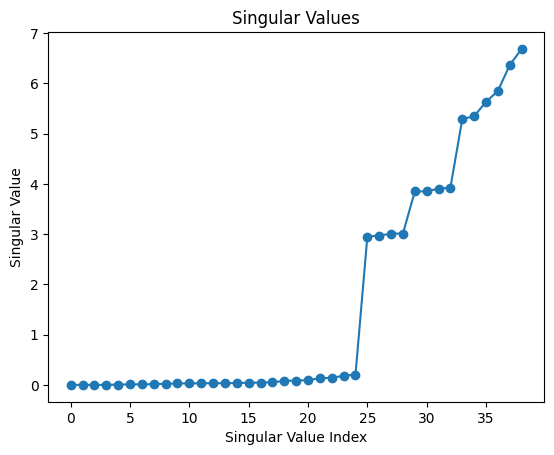

In [125]:
hl_faulty_noisy = HamiltonianLearning(DensityMatrix(faulty_state),2,3)
hl_faulty_noisy.sample_paulis()
hl_faulty_noisy.sampled_paulis += np.random.normal(0,1e-3,hl_faulty_noisy.sampled_paulis.shape)
hl_faulty_noisy.create_constraint_matrix()
hl_faulty_noisy.reconstruct_hamiltonian()

singular_values = [r[0] for r in hl_faulty_noisy.singular_decomposition]
print(singular_values[:5])
plt.plot(singular_values[:], marker="o")
plt.title("Singular Values")
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value")


We see that in the presence of noise while sampling, instead of having a clear gap between the first and second singular values, we have an unclear gap between the 25th and 26th singular values. Unfortunately this means that we will have to consider more than one of those singular vectors.
What we have learned, however, is that our Hamiltonian lies in the subspace spaned by these vectors.

What we can start by doing is to project our original hamiltoinan onto this subspace.

In [120]:
projection, coeffs = hl_faulty_noisy.project_hamiltonian(l=15,hamiltonian = H_original)
cos = np.dot(projection,c_hat_original)/np.linalg.norm(projection) #cosine of the angle between the subspace and the original hamiltonian
c_guessed_noisy = projection/np.linalg.norm(projection) * np.linalg.norm(c_original) / cos
print(np.linalg.norm(c_faulty-c_guessed_noisy) / np.linalg.norm(c_original))

0.1424837647524708


A tricky part of this method is correctly estimating the dimension of the space in which to project our state. There is an optimal ammount of terms to consider in order to get the best reconstruction possible. We need at least a few terms so that we can express all the components of our Faulty Hamiltonian, but if we take to many of them we will overfit onto the original Hamiltonian.

(0.0, 38.0)

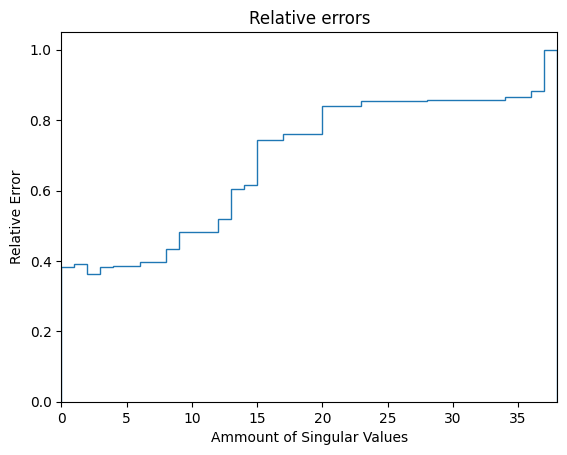

In [121]:
norms = []
for l in range(1,len(singular_values)):
    projection, coeffs = hl_faulty_noisy.project_hamiltonian(l=l,hamiltonian = H_original)
    
    norms.append(np.linalg.norm(c_faulty-projection) / np.linalg.norm(c_faulty-c_original))

plt.stairs(norms)
plt.title("Relative errors")
plt.xlabel("Ammount of Singular Values")
plt.ylabel("Relative Error")
plt.xlim(0, len(norms))